In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash')
result = model.invoke("Hi")
print(result)

content='Hi there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []} id='run--3e7536c6-fe23-4cf6-a941-99bc50c292e1-0' usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}}


Step 2: We do embeddings

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

Step 3: Create Vector Database

In [4]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma 
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
loader = DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)

In [6]:
docs = loader.load()
# we need to divide data into multiple chunks

In [7]:
docs[0]

Document(metadata={'source': '..\\data2\\usa.txt'}, page_content="ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP â€“ Size, Composition, and Global Share\nAs of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China 

In [8]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 50
)

In [9]:
new_docs = text_splitter.split_documents(documents = docs)

In [10]:
new_docs

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='innovation, global 

In [11]:
from langchain_community.vectorstores import FAISS

vector_db = FAISS.from_documents(new_docs, embeddings)


Step 4: Use this vector db as retriever to retrieve data

In [12]:
retriever = vector_db.as_retriever(search_kwargs={"k" : 3})

In [13]:
retriever.invoke("Whats is industrial growth of USA")

[Document(id='69e79ce8-0a06-4adf-a0ff-0a1aa74198fe', metadata={'source': '..\\data2\\usa.txt'}, page_content='ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy'),
 Document(id='2c1a2859-4f1f-4a89-86be-44a4cad747b6', metadata={'source': '..\\data2\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administrationâ€™s Inflation'),
 Document(id='5fbad12e-399b-4c44-afe9-5804155465f0', metadata={'source': '..\\data2\\usa.txt'}, page_content='GDP Growth Trends and Dynamics')]

Step 5 We need to you this retriver as a node in out Agentic Workflow but we also need pydantic for datatype validation

In [14]:
from pydantic import BaseModel, Field

In [15]:
class TopicSelectionParser(BaseModel):
    Topic : str=Field(description="selected topic")
    Reasoning : str= Field(description="selected topic")

In [16]:
from langchain.output_parsers import PydanticOutputParser

In [17]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [18]:
parser.get_format_instructions

<bound method PydanticOutputParser.get_format_instructions of PydanticOutputParser(pydantic_object=<class '__main__.TopicSelectionParser'>)>

In [19]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END


In [20]:
class AgentState(TypedDict):
    message: Annotated[Sequence[BaseModel],operator.add]

In [21]:
AgentState={}

In [22]:
AgentState["messages"]=[]

In [23]:
AgentState

{'messages': []}

In [24]:
AgentState["messages"].append("Hi, how are you?")

In [76]:
AgentState

{'messages': ['Hi, how are you?']}

In [25]:
AgentState["messages"].append("Supp")

In [26]:
AgentState

{'messages': ['Hi, how are you?', 'Supp']}

In [27]:
AgentState["messages"].append("Reply to me")

In [28]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [29]:
# state={"messages":["hi"]}

In [30]:
# state="hi"

message[-1] is my recent message

In [31]:
def function_1(state:AgentState):
    
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [34]:
state={"messages":["Whats GDP of USA?"]}

In [35]:
function_1(state)

Question Whats GDP of USA?
Parsed response: Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'


{'messages': ['USA']}

In [ ]:
def router(state:AgentState):
    print("->->Router->->")

    last_message = state["messages"][-1]
    print("Last Message",last_message)

    if "usa" in last_message.lower():
        return "RAG"
    else:
        return "LLM Call"

In [1]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [71]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [55]:
# LLM Function

def function_3(state:AgentState):
    print("->->LLM Call->->")

    question = state["messages"][0]

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [43]:
from langgraph.graph import StateGraph, END

In [72]:
workflow = StateGraph(AgentState)

In [73]:
workflow.add_node("Supervisor",function_1)

In [74]:
workflow.add_node("RAG",function_2)

In [75]:
workflow.add_node("LLM Call",function_3)

In [76]:
workflow.set_entry_point("Supervisor")

In [77]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG" : "RAG",
        "LLM Call" : "LLM Call"
    }
)

In [78]:
workflow.add_edge("RAG", END)
workflow.add_edge("LLM Call", END)

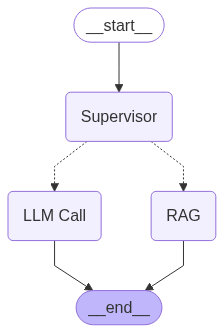

In [79]:
workflow.compile()

In [66]:
state={"messages":["Hi"]}

In [67]:
workflow.compile().invoke(state)

Question Hi
Parsed response: Topic='Not Related' Reasoning="The query 'Hi' is a greeting and does not contain any information related to the USA."
->->Router->->
Last Message Not Related
->->LLM Call->->


{'messages': ['Hi', 'Not Related', 'Hi there! How can I help you today?']}

In [84]:
state={"messages":["Tell me GDP of USA"]}

In [85]:
workflow.compile().invoke(state)

Question Tell me GDP of USA
Parsed response: Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'
->->Router->->
Last Message USA
-> RAG Call ->


{'messages': ['Tell me GDP of USA',
  'USA',
  'As of 2024, the U.S. nominal GDP is estimated at approximately $28 trillion.  This represents about 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.']}